In [114]:
#coding:utf-8
%reload_ext autoreload 
%autoreload 2
import os
import sys

project_basedir = '..'
sys.path.append(project_basedir)
from cchess_zero import cbf
from cchess_zero import board_visualizer
from matplotlib import pyplot as plt
import os
from cchess_zero.gameboard import *
from net import resnet
import common
from gameplays import gameplay,players
from gameplays.analysis import get_km_json
import json
%matplotlib inline
gpu_core = 6
import os
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_core)

In [115]:
!date

2018年 09月 02日 星期日 19:23:43 CST


In [155]:
! ls -l '../data/validate/2018-09-11_21-13-25_noup/' | tail

-rw-rw-r-- 1 meta meta 2678  9月 11 21:59 2018-09-11_21-59-23_261_mcts-mcts_newnet-oldnet_b.cbf
-rw-rw-r-- 1 meta meta 6503  9月 11 21:59 2018-09-11_21-59-37_504_mcts-mcts_oldnet-newnet_peace.cbf
-rw-rw-r-- 1 meta meta 1828  9月 11 21:59 2018-09-11_21-59-52_842_mcts-mcts_newnet-oldnet_b.cbf
-rw-rw-r-- 1 meta meta 5978  9月 11 22:00 2018-09-11_22-00-08_488_mcts-mcts_oldnet-newnet_b.cbf
-rw-rw-r-- 1 meta meta 6853  9月 11 22:02 2018-09-11_22-02-24_679_mcts-mcts_newnet-oldnet_peace.cbf
-rw-rw-r-- 1 meta meta 6178  9月 11 22:02 2018-09-11_22-02-34_695_mcts-mcts_oldnet-newnet_b.cbf
-rw-rw-r-- 1 meta meta 7103  9月 11 22:03 2018-09-11_22-03-57_607_mcts-mcts_newnet-oldnet_peace.cbf
-rw-rw-r-- 1 meta meta 1978  9月 11 22:04 2018-09-11_22-04-18_838_mcts-mcts_newnet-oldnet_b.cbf
-rw-rw-r-- 1 meta meta 7653  9月 11 22:05 2018-09-11_22-05-13_130_mcts-mcts_newnet-oldnet_peace.cbf
-rw-rw-r-- 1 meta meta 2003  9月 11 22:05 2018-09-11_22-05-30_865_mcts-mcts_newnet-oldnet_w.cbf


In [156]:
! ls -l '../data/validate/2018-09-11_21-13-25_noup/' | wc -l

29


In [157]:
! ls -l '../data/validate/2018-09-11_21-13-25_noup/' | grep peace | wc -l

8


In [159]:

fullpath = '../data/validate/2018-09-11_21-13-25_noup/2018-09-11_22-02-34_695_mcts-mcts_oldnet-newnet_b.cbf'
moves = cbf.cbf2move(fullpath)
fname = fullpath.split('/')[-1]
print(fname)
state = gameplay.GameState()

2018-09-11_22-02-34_695_mcts-mcts_oldnet-newnet_b.cbf


In [160]:
from PIL import Image
import imageio
imgs_for_gif = []
state = gameplay.GameState()
statestr = 'RNBAKABNR/9/1C5C1/P1P1P1P1P/9/9/p1p1p1p1p/1c5c1/9/rnbakabnr'
for i in moves[:]: 
    statestr = GameBoard.sim_do_action(i,statestr)
    imgs_for_gif.append(board_visualizer.get_board_img(statestr))
    state.do_move(i)
imgs_for_gif = imgs_for_gif[:]
imageio.mimsave('../data/gif/{}.gif'.format(fname[:-4]), imgs_for_gif,duration=0.5)

In [161]:
i,len(moves)

('d0e0', 211)

In [162]:
def display_gif(fn):
    from IPython import display
    return display.HTML('<img src="{}">'.format(fn))

In [163]:
display_gif('../data/gif/{}.gif'.format(fname[:-4]))

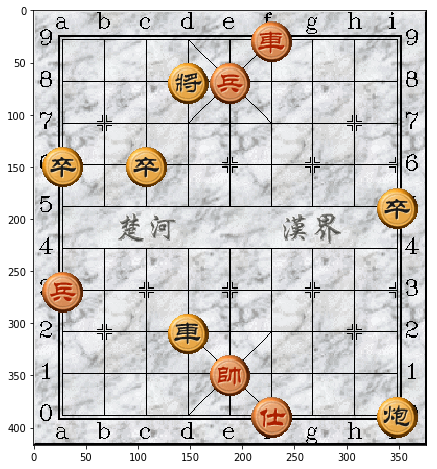

In [142]:
plt.figure(figsize=(8,8))
plt.imshow(board_visualizer.get_board_img(statestr))

# ANALYSIS

In [7]:
network = resnet.get_model(os.path.join(project_basedir,
    '../data/download_weight/2018-09-02_12-13-24'[3:]),
    common.board.create_uci_labels(),GPU_CORE=[gpu_core],FILTERS=128,NUM_RES_LAYERS=7)

0
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
inside res net [None, 10, 9, 128]
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

INFO:tensorflow:Restoring parameters from ../data/download_weight/2018-08-27_22-13-25


In [24]:
network_player = players.NetworkPlayer(state.currentplayer,network,n_playout=400)

In [25]:
network_player.make_move(state=state,actual_move=False)

find something to cut off
find something to cut off
find something to cut off
find something to cut off
find something to cut off
find something to cut off
find something to cut off
find something to cut off
find something to cut off
find something to cut off
find something to cut off
find something to cut off
find something to cut off
find something to cut off
find something to cut off
find something to cut off
find something to cut off
find something to cut off
find something to cut off
find something to cut off
find something to cut off
find something to cut off
find something to cut off
find something to cut off


('b8b9', 0.9842767763011004)

In [26]:
network_player.mcts_policy._root._Q

-0.9842767763011004

In [27]:
childs = network_player.mcts_policy._root._children
for move in childs:
    val = childs[move]
    print(move,val._n_visits,val._P,val._Q)

b8b7 27 0.0016278382 0.9836205994641342
f5f2 0 1.3908269e-05 0
e2c4 0 2.4689805e-07 0
b8b5 26 0.00022104873 0.9747510391932268
e0f0 25 0.00019239952 0.9945049023628234
b8a8 0 5.2943305e-06 0
g3g4 0 2.0238604e-06 0
e1f2 0 6.348523e-09 0
b8b1 0 9.861998e-06 0
b8b6 28 0.00095658266 0.97982357442379
f5f6 0 4.3672568e-05 0
b8g8 26 7.4871554e-05 0.9837877865021045
f5i5 0 3.6963047e-05 0
f5f9 12 0.0026605285 0.9494677484035491
e2c0 0 7.105041e-07 0
f5g5 0 5.9339935e-05 0
f5b5 0 2.886729e-05 0
b8i8 5 9.804602e-05 0.9695721864700317
b8f8 28 0.0002258167 0.98564427452428
f5a5 0 5.0954136e-06 0
b8b2 0 9.154137e-06 0
b8c8 0 5.912576e-06 0
f5f1 0 1.060783e-05 0
f5d5 0 6.577528e-05 0
a3a4 0 5.869633e-09 0
f5f8 32 0.0002923336 0.9956058375537397
g0i2 0 2.8637107e-08 0
b8b4 0 3.997466e-05 0
b8b9 43 0.0057196007 0.9858605528986731
f5e5 0 0.9823209 0
b8b3 28 0.00014513661 0.9886630624532698
b8b0 0 2.0824378e-05 0
b8d8 8 9.348374e-05 0.9687948375940323
e1d2 0 7.71974e-09 0
f5h5 28 0.0001799077 0.98836477

In [31]:
datajson = get_km_json(network_player.mcts_policy,state.statestr,depth=40)

In [32]:
!mkdir '../data/mstc_vis'

mkdir: cannot create directory ‘../data/mstc_vis’: File exists


In [33]:
with open('../data/mstc_vis/sample.km','w') as whdl:
    json.dump(datajson,whdl)